# Test GEModelTools - HANC

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Step 1: Find Steady state](#toc2_)    
  - 2.1. [Idiosyncratic productivity](#toc2_1_)    
  - 2.2. [Policy functions](#toc2_2_)    
  - 2.3. [Simulation](#toc2_3_)    
- 3. [Tests](#toc3_)    
- 4. [Step 2: Compute Jacobians](#toc4_)    
- 5. [Step 3a: Find non-linear transition_path](#toc5_)    
- 6. [Step 3b: Find linearized IRFs](#toc6_)    
- 7. [Decompositions](#toc7_)    
  - 7.1. [Household behavior](#toc7_1_)    
  - 7.2. [Blocks](#toc7_2_)    
- 8. [Custom shocks](#toc8_)    
  - 8.1. [Path](#toc8_1_)    
  - 8.2. [Initial distribution](#toc8_2_)    
- 9. [Step 4. Simulation](#toc9_)    
- 10. [Changing unknowns, shocks and targets](#toc10_)    
- 11. [Example: Idiosyncratic risk and the steady state interest rate](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a simple Heterogenous Agent Neo-Classical (HANC) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

Show **information**:

In [3]:
model.info()

settings:
 par.py_hh = False
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w]
 inputs_hh_z: []
 outputs_hh: [a,c,l]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma]
 unknowns: [K,L]
 targets: [clearing_A,clearing_L]

blocks (inputs -> outputs):
 capital_accumulation: [K] -> [K_lag,I]
 production_firm: [Gamma,K_lag,L] -> [rk,w,Y]
 mutual_fund: [K,rk] -> [A,r]
 hh: [r,w] -> [A_hh,C_hh,L_hh]
 market_clearing: [A,A_hh,L,L_hh,Y,C_hh,I] -> [clearing_A,clearing_L,clearing_Y]


Show **DAG**:

capital_accumulation: [K] -> [K_lag,I]
production_firm: [Gamma,K_lag,L] -> [rk,w,Y]
mutual_fund: [K,rk] -> [A,r]
hh: [r,w] -> [A_hh,C_hh,L_hh]
market_clearing: [A,A_hh,L,L_hh,Y,C_hh,I] -> [clearing_A,clearing_L,clearing_Y]


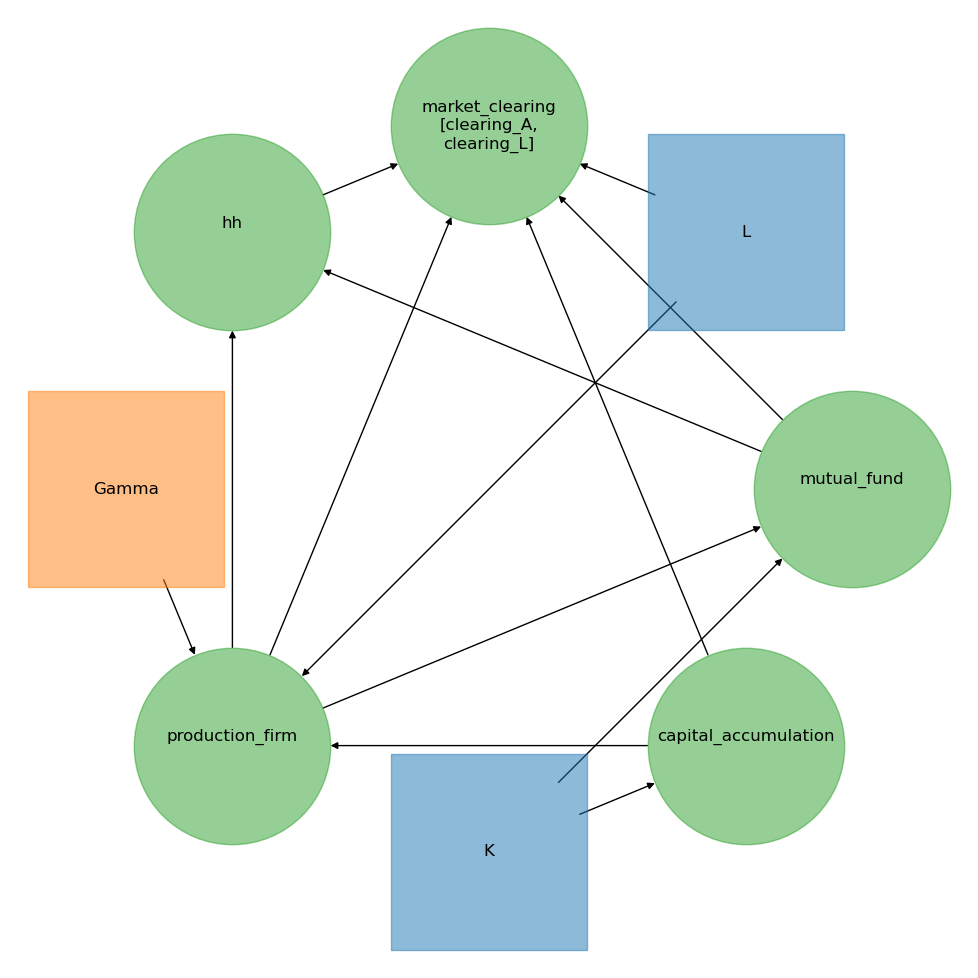

In [4]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

Detailed information:

In [5]:
print(model) # take a look inside

Modelclass: HANCModelClass
Name: baseline

namespaces: ['par', 'ini', 'sim', 'ss', 'path']
other_attrs: ['grids_hh', 'pols_hh', 'inputs_hh', 'inputs_hh_z', 'outputs_hh', 'intertemps_hh', 'shocks', 'unknowns', 'targets', 'varlist', 'blocks', 'jac', 'H_U', 'H_Z', 'jac_hh', 'IRF']
savefolder: saved
cpp_filename: None

par:
 Nfix = 3 [int]
 Nz = 7 [int]
 sigma = 2.0 [float]
 beta_mean = 0.975 [float]
 beta_delta = 0.01 [float]
 rho_z = 0.95 [float]
 sigma_psi = 0.09367496997597599 [float]
 alpha = 0.36 [float]
 delta = nan [float]
 r_ss_target = 0.01 [float]
 w_ss_target = 1.0 [float]
 a_max = 500.0 [float]
 Na = 300 [int]
 jump_Gamma = -0.1 [float]
 rho_Gamma = 0.9 [float]
 std_Gamma = 0.01 [float]
 T = 500 [int]
 simT = 2000 [int]
 max_iter_solve = 50000 [int]
 max_iter_simulate = 50000 [int]
 max_iter_broyden = 100 [int]
 tol_solve = 1e-12 [float]
 tol_simulate = 1e-12 [float]
 tol_broyden = 1e-10 [float]
 py_hh = False [bool]
 py_block = True [bool]
 full_z_trans = False [bool]
 Nbeta 

## 2. <a id='toc2_'></a>[Step 1: Find Steady state](#toc0_)

**Task:** We need to find

1. All variables in `.ss`
1. The steady state policy functions `ss.a` and `ss.c`
1. The steady state distributions `ss.Dbeg` and `ss.D`
1. The steady state aggregates `ss.A_hh` and `ss.C_hh`

In `.prepare_hh_ss()` [called in `.solve_hh_ss()` used in `.find_ss()`] we specify:

1. All grids in `.par` (can depend on steady state values prior to the household problem)
1. Initial guess for `ss.Dbeg` when iterating *forwards*
1. Initial guess for `ss.vbeg_a` when iterating *backwards*

In [6]:
model.find_ss(do_print=True,method='indirect')

household problem in ss solved in 5.7 secs [1287 iterations]
household problem in ss simulated in 4.6 secs [1438 iterations]

Implied K =  2.775
Implied Y =  1.562
Implied Gamma =  1.082
Implied delta =  0.193
Implied K/Y =  1.776
Discrepancy in A =   0.00000000
Discrepancy in L =   0.00000000
Discrepancy in Y =   0.00000000
found steady state in 11.0 secs


In [7]:
model.info(only_blocks=True,ss=True)

capital_accumulation: [K=2.78] -> [K_lag=2.78,I=0.53]
production_firm: [Gamma=1.08,K_lag=2.78,L=1.00] -> [rk=0.20,w=1.00,Y=1.56]
mutual_fund: [K=2.78,rk=0.20] -> [A=2.78,r=0.01]
hh: [r=0.01,w=1.00] -> [A_hh=2.78,C_hh=1.03,L_hh=1.00]
market_clearing: [A=2.78,A_hh=2.78,L=1.00,L_hh=1.00,Y=1.56,C_hh=1.03,I=0.53] -> [clearing_A=0.00,clearing_L=0.00,clearing_Y=0.00]


**Unpack:** For easy access later on.

In [8]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

**Solve and simumlate again:** Faster because the code has been numba-compiled.

In [9]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

[autoreload of GEModelTools.GEModelClass failed: Traceback (most recent call last):
  File "c:\Users\gmf123\AppData\Local\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\gmf123\AppData\Local\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "c:\Users\gmf123\AppData\Local\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\users\gmf123\dropbox\repositories\gemodeltools\GEModelTools\GEModelClass.py", line 387
    <<<

household problem in ss solved in 0.9 secs [1287 iterations]
household problem in ss simulated in 0.2 secs [1438 iterations]


### 2.1. <a id='toc2_1_'></a>[Idiosyncratic productivity](#toc0_)

**Productivity states:** A closer look at the productivity process.

In [10]:
Dz = np.sum(ss.D,axis=2)
for i_fix in range(par.Nfix):
    
    beta = par.beta_grid[i_fix]
    print(f'{beta = :.2f}')
    for z,pr_z in zip(par.z_grid,Dz[i_fix]):
        print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

print('')

ss_mean_z = np.sum(par.z_grid*Dz)
ss_mean_log_z = np.sum(np.log(par.z_grid)*Dz)
print(f'mean(z): {ss_mean_z:.3f}')
assert np.isclose(ss_mean_z,1.0)

ss_std_z = np.sqrt(np.sum(Dz*(par.z_grid-ss_mean_z)**2))
print(f'std(z): {ss_std_z:.3f}')

ss_std_z = np.sqrt(np.sum(Dz*(np.log(par.z_grid)-ss_mean_log_z)**2))
print(f'std(log(z)): {ss_std_z:.3f}')

# note: the steady state transition matrix is in ss.z_trans

beta = 0.96
 Pr[z = 0.4585] = 0.0052
 Pr[z = 0.5858] = 0.0312
 Pr[z = 0.7484] = 0.0781
 Pr[z = 0.9561] = 0.1042
 Pr[z = 1.2215] = 0.0781
 Pr[z = 1.5605] = 0.0312
 Pr[z = 1.9936] = 0.0052
beta = 0.97
 Pr[z = 0.4585] = 0.0052
 Pr[z = 0.5858] = 0.0312
 Pr[z = 0.7484] = 0.0781
 Pr[z = 0.9561] = 0.1042
 Pr[z = 1.2215] = 0.0781
 Pr[z = 1.5605] = 0.0312
 Pr[z = 1.9936] = 0.0052
beta = 0.98
 Pr[z = 0.4585] = 0.0052
 Pr[z = 0.5858] = 0.0312
 Pr[z = 0.7484] = 0.0781
 Pr[z = 0.9561] = 0.1042
 Pr[z = 1.2215] = 0.0781
 Pr[z = 1.5605] = 0.0312
 Pr[z = 1.9936] = 0.0052

mean(z): 1.000
std(z): 0.304
std(log(z)): 0.300


**Grids:**

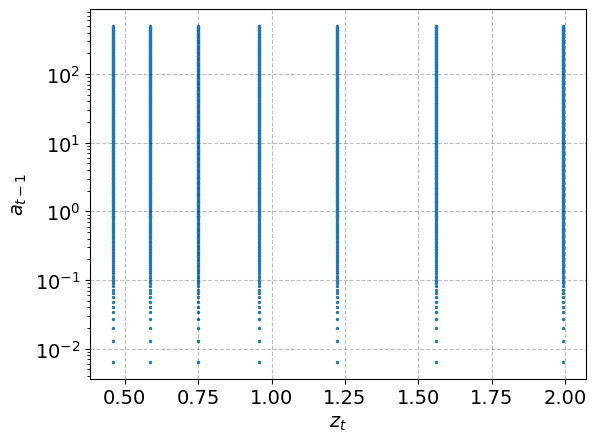

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

z_grid,a_grid = np.meshgrid(par.z_grid,par.a_grid,indexing='ij')
ax.scatter(z_grid,a_grid,2)

ax.set_yscale('log')
ax.set_xlabel('$z_t$')
ax.set_ylabel('$a_{t-1}$');

**Transition matrix for $z_t$:**

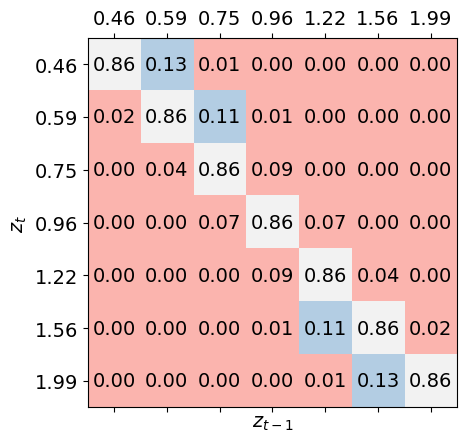

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(False)
i_fix = 0
h = ax.matshow(ss.z_trans[i_fix],cmap='Pastel1')

for (i, j), value in np.ndenumerate(ss.z_trans[i_fix]):
    ax.text(j, i, f'{value:0.2f}', ha='center', va='center')
    
z_labels = [f'{z:.2f}' for z in par.z_grid]
xaxis = np.arange(par.z_grid.size)
ax.set_xticks(xaxis)
ax.set_xticklabels(z_labels) 
ax.set_yticks(xaxis)
ax.set_yticklabels(z_labels) 

ax.set_xlabel('$z_{t-1}$')
ax.set_ylabel('$z_{t}$');

**Ergodic distribution:**

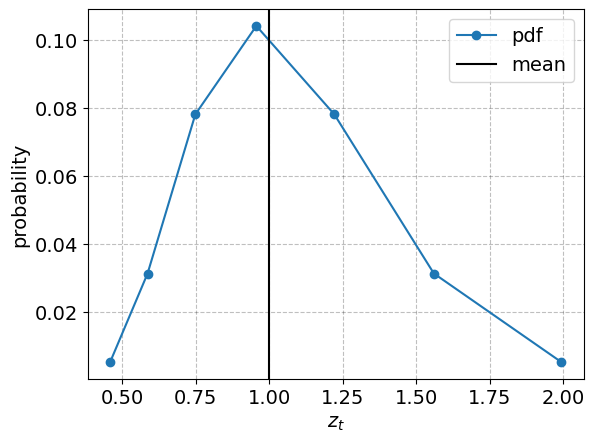

In [13]:
Dz = np.sum(ss.D,axis=2)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
i_fix = 0
ax.plot(par.z_grid,Dz[i_fix],'-o',label='pdf')
ax.axvline(np.sum(par.z_grid*Dz),color='black',label='mean')
ax.set_xlabel('$z_t$')
ax.set_ylabel('probability')
ax.legend(frameon=True);

### 2.2. <a id='toc2_2_'></a>[Policy functions](#toc0_)

The steady state policy functions are in `ss.a` and `ss.c`.

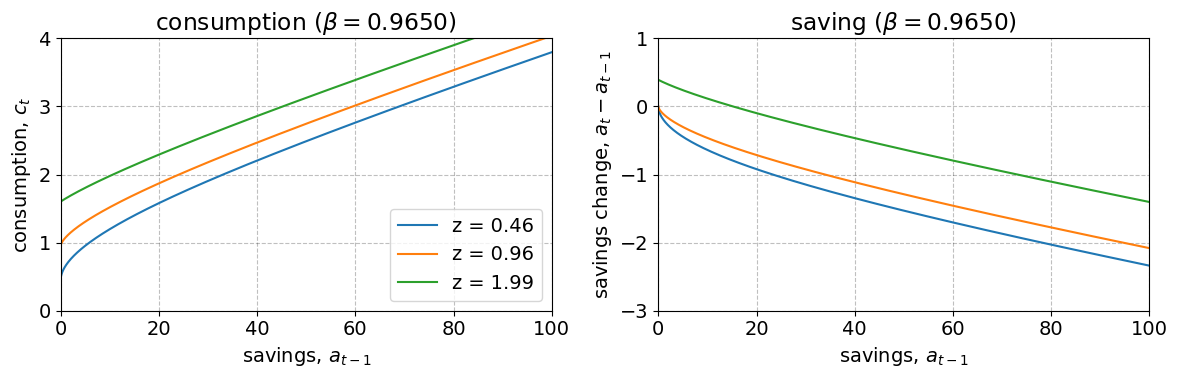

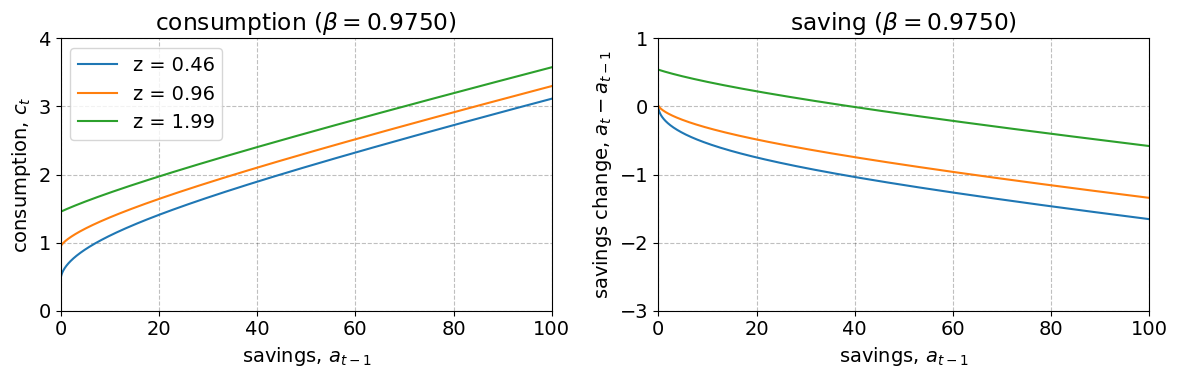

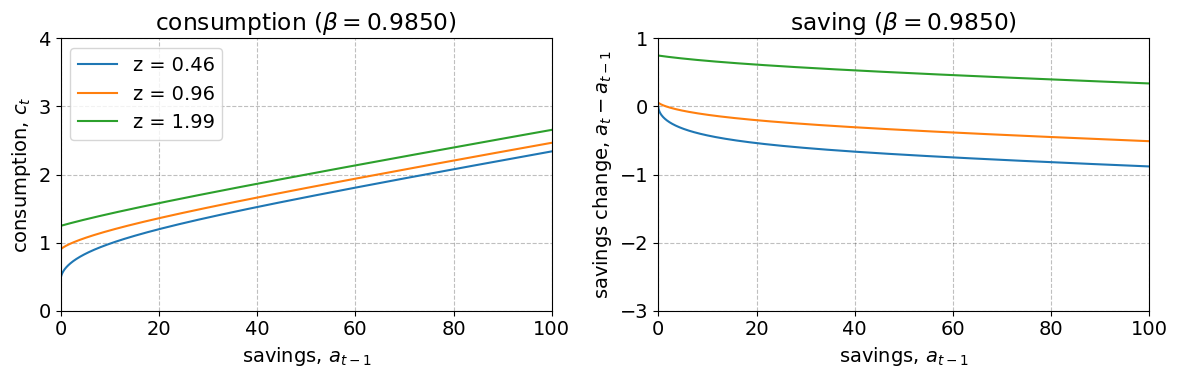

In [14]:
for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    ax.set_xlim(0,100)
    ax.set_ylim(0,4)

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,1)

    fig.tight_layout()
    fig.savefig(f'figs/c_func_{i_beta}.pdf')

### 2.3. <a id='toc2_3_'></a>[Simulation](#toc0_)

The steady state distribution is in `ss.D` where `ss.D.shape == [par.Nbeta,par.Nz,par.Na]`

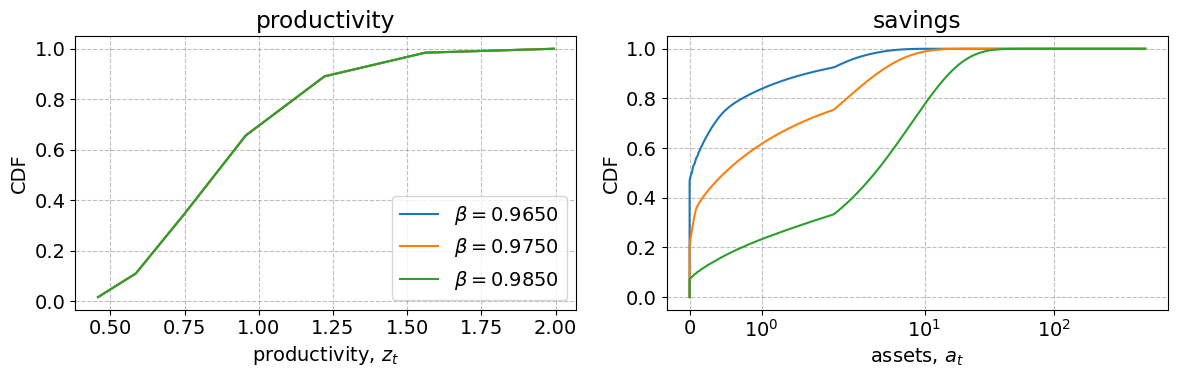

In [15]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
for i_beta,beta in enumerate(par.beta_grid):
    ax.plot(par.z_grid,np.cumsum(np.sum(ss.D[i_beta],axis=1))*par.Nfix,label=f'$\\beta = {beta:.4f}$')

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')
ax.legend()

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
for i_beta in range(par.Nfix):
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D[i_beta],axis=0)),0,0.0)*par.Nfix,label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

fig.tight_layout()
fig.savefig('figs/distribution.pdf')

**Income moments:**

In [16]:
mean_z = np.sum(ss.D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(ss.D*(par.z_grid[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.30


**Asset moments:**

In [17]:
# a. prepare
Da = np.sum(ss.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a:  2.775
p25  a:  0.001
p50  a:  0.616
p95  a: 12.911
p99  a: 23.004
std. a:  4.898


**MPC:**

In [18]:
MPC = np.zeros(ss.D.shape)
dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
dm = (1+ss.r)*(par.a_grid[np.newaxis,np.newaxis,1:]-par.a_grid[np.newaxis,np.newaxis,:-1])
MPC[:,:,:-1] = dc/dm
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

mean MPC: 0.269 [annual: 0.714]


## 3. <a id='toc3_'></a>[Tests](#toc0_)

Here we run a couple of tests to show that the code behaves as expected. This is especially valuable when developing a new model.

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.6 secs
household problem simulated along transition in 1.5 secs



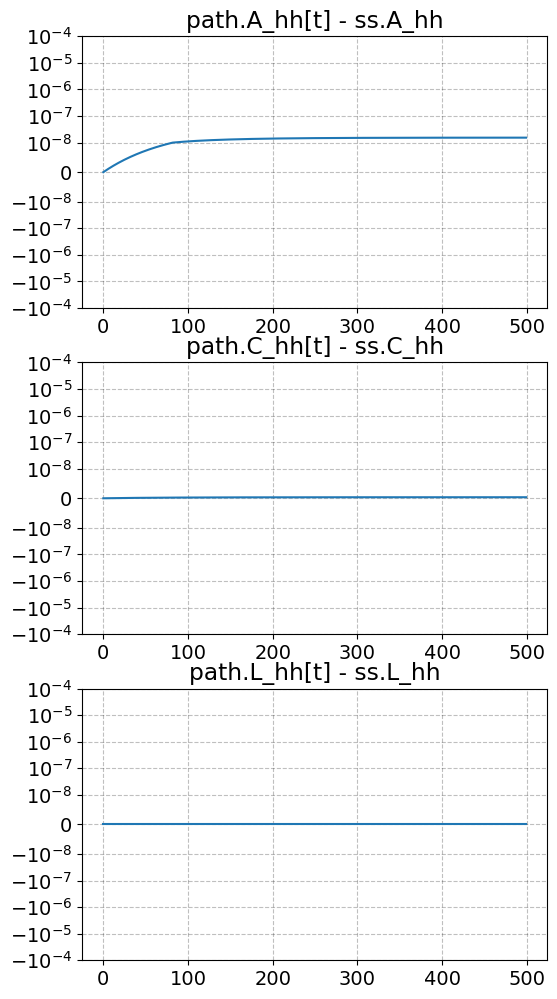

In [19]:
model.test_hh_path()

**Full transition path:**

In [20]:
model.test_path()

shocks: Gamma 
unknowns: K L 

blocks.capital_accumulation
 K_lag            0.0e+00
 I                0.0e+00
blocks.production_firm
 rk               0.0e+00
 w                0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                8.7e-18
hh
 A_hh             1.5e-08
 C_hh             3.5e-10
 L_hh             2.9e-15
blocks.market_clearing
 clearing_A       1.5e-08 [target]
 clearing_L       2.0e-14 [target]
 clearing_Y       3.5e-10


**Calculation of Jacobians:**

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 125 250 375 [computed in 1.1 secs]
finding Jacobian wrt. r              : 0 125 250 375 [computed in 1.2 secs]
finding Jacobian wrt. w              : 0 125 250 375 [computed in 1.1 secs]
household Jacobian computed in 3.6 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.5 secs
curly_Y and curly_D calculated for w               in 0.5 secs
curly_E calculated in 2.2 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 3.4 secs

full Jacobian to unknowns computed in 0.5 secs [in evaluate_blocks(): 0.2 secs]
full Jacobian to shocks computed in 0.3 secs [in evaluate_blocks(): 0.1 secs]


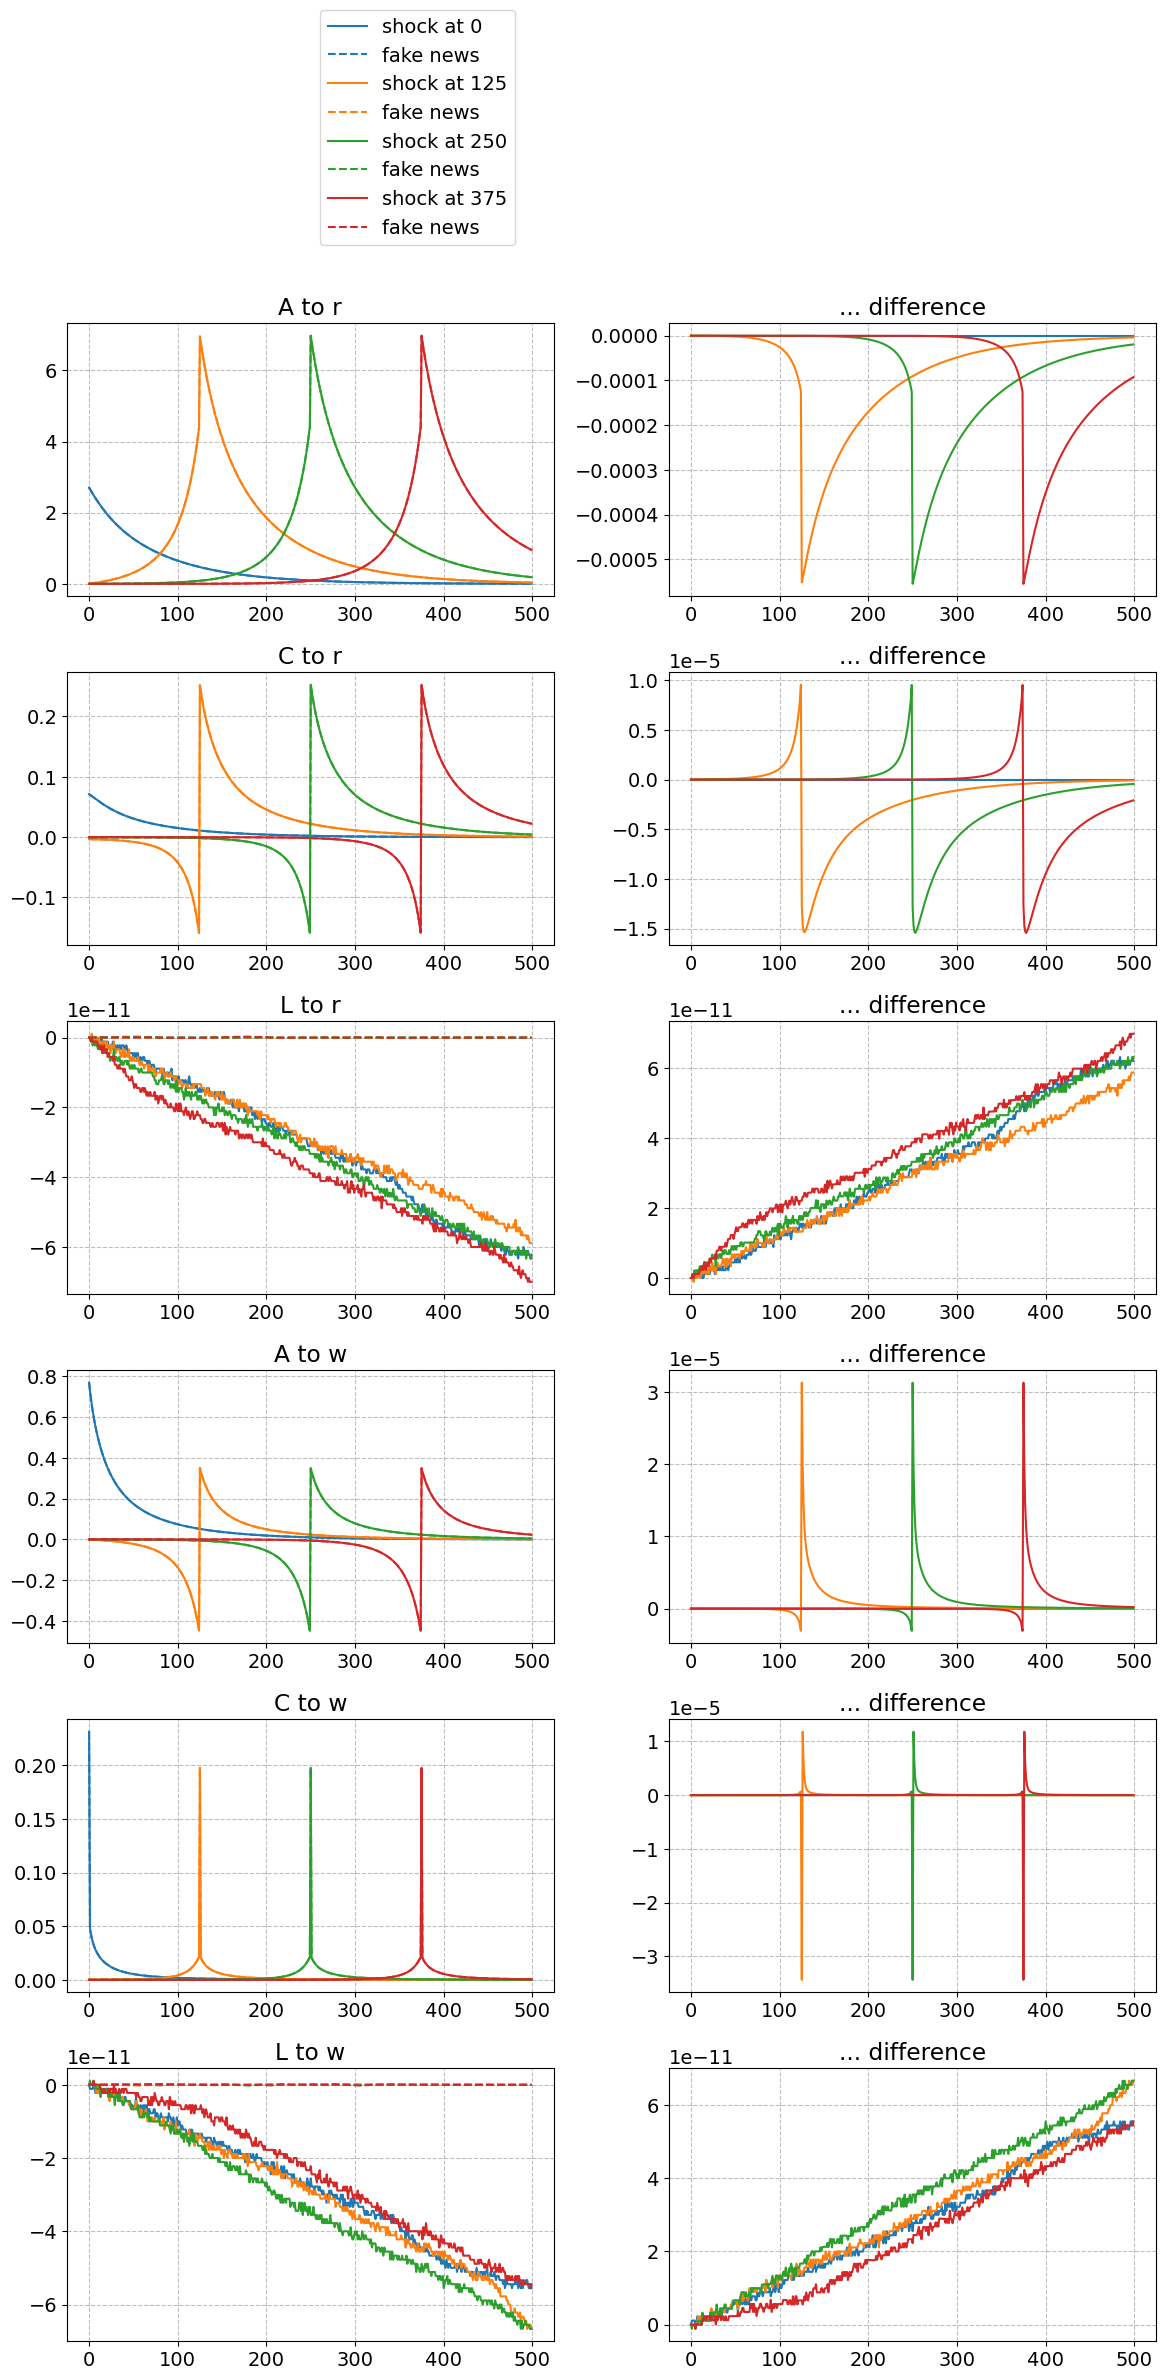

In [21]:
model.test_jacs()

## 4. <a id='toc4_'></a>[Step 2: Compute Jacobians](#toc0_)

In [22]:
model.compute_jacs(do_print=True) # if skip_shocks = True the full Jacobians to shocks are  not computed

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.6 secs
curly_Y and curly_D calculated for w               in 0.6 secs
curly_E calculated in 0.3 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 1.7 secs

full Jacobians:
full Jacobian to unknowns computed in 0.6 secs [in evaluate_blocks(): 0.2 secs]
full Jacobian to shocks computed in 0.4 secs [in evaluate_blocks(): 0.1 secs]


The Jacobians are saved in:

1. **household Jacobians**: `model.jac_hh` is a dictionary with keys `(Outputname_hh,inputname)`
1. **full Jacobian to *unknowns***: `model.H_U` is a matrix
1. **full Jacobian to *shocks***: `model.H_Z` is a matrix
1. **full Jacobians**: `model.jac` is a dictionary with keys `(outputname,inputname)`

The **household Jacobians** are e.g. informative to look at.

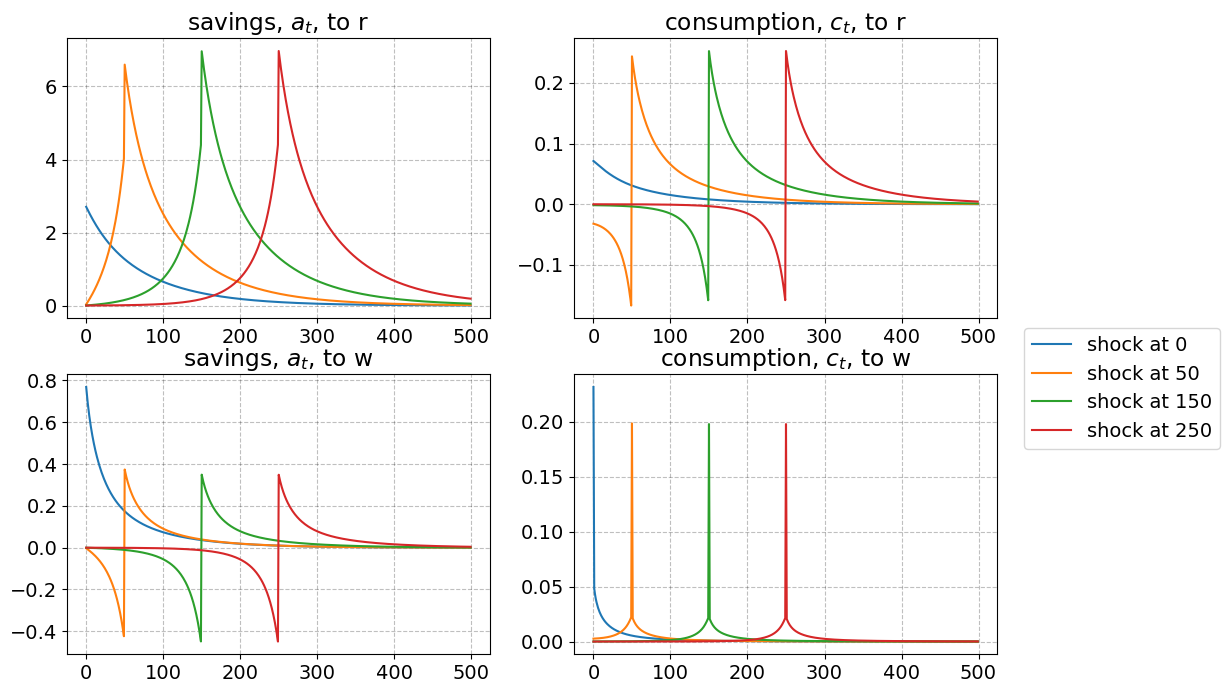

In [23]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

## 5. <a id='toc5_'></a>[Step 3a: Find non-linear transition_path](#toc0_)

In [24]:
model.find_transition_path(shocks=['Gamma'],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 7.53e-01
   7.53e-01 in clearing_A
   2.51e-14 in clearing_L
 it =   1 -> max. abs. error = 8.27e-02
   8.27e-02 in clearing_A
   9.99e-16 in clearing_L
 it =   2 -> max. abs. error = 9.59e-03
   9.59e-03 in clearing_A
   7.77e-16 in clearing_L
 it =   3 -> max. abs. error = 1.62e-04
   1.62e-04 in clearing_A
   4.44e-16 in clearing_L
 it =   4 -> max. abs. error = 8.25e-06
   8.25e-06 in clearing_A
   4.44e-16 in clearing_L
 it =   5 -> max. abs. error = 9.17e-08
   9.17e-08 in clearing_A
   5.55e-16 in clearing_L
 it =   6 -> max. abs. error = 1.21e-10
   1.21e-10 in clearing_A
   5.55e-16 in clearing_L
 it =   7 -> max. abs. error = 2.54e-12
   2.54e-12 in clearing_A
   6.66e-16 in clearing_L

transition path found in 4.7 secs


**Results:** We now have

1. The transition path of all variables, `path.VARNAME.shape == (par.T,1)`
1. The transition path of policy functions, `path.a` and `path.c`
1. The transition path of distributions, `path.D`

The **timing** is such that `path.A_hh[t] == np.sum(path.a[t]*path.D[t])`.

In [25]:
diff = path.A_hh-np.sum(path.a*path.D,axis=(1,2,3))[:,np.newaxis]
max_abs_diff = np.max(np.abs(diff))
print(f'{max_abs_diff = }')

max_abs_diff = 0.0


**Plot transitions**

### shocks ###


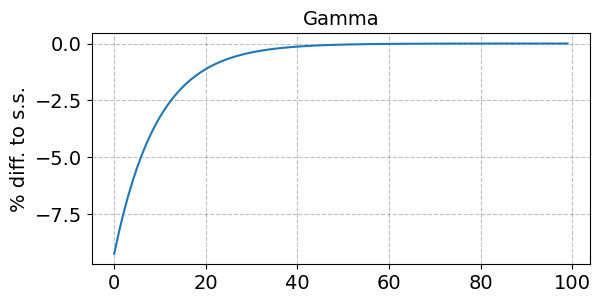


### varnames ###


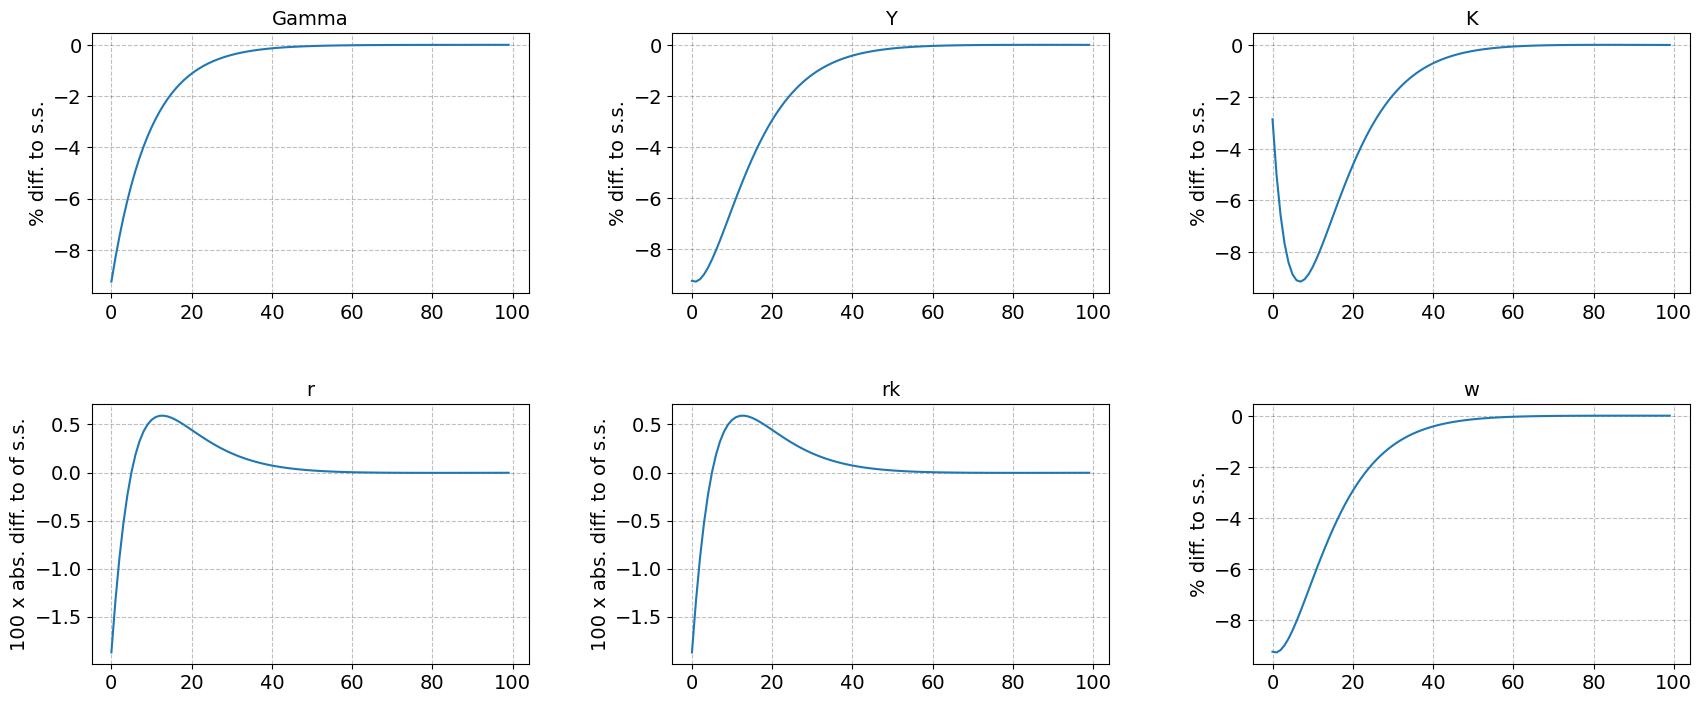


### tagets ###


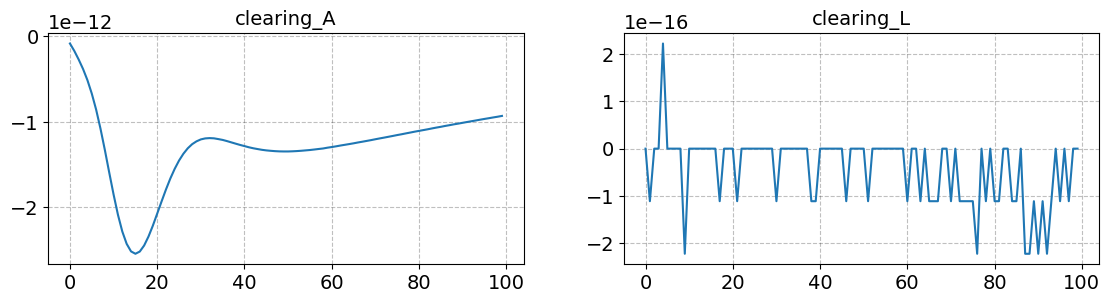

In [26]:
paths = ['Gamma','Y','K','r','rk','w']
abs_diff = ['r','rk']
facs = {'r':100,'rk':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,filename='figs/technology_shock')

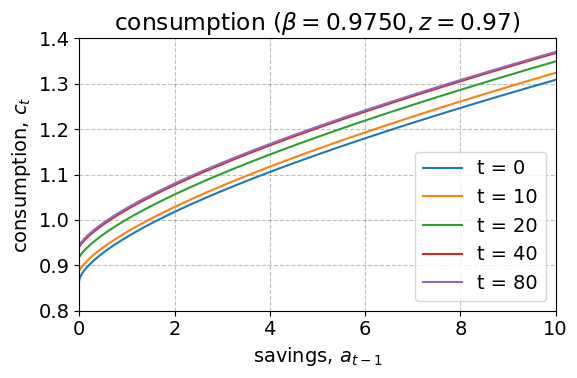

In [27]:
i_beta = 1
i_z = par.Nz//2
beta = par.beta_grid[i_beta]
z = par.z_grid[i_z]

fig = plt.figure(figsize=(6,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,1,1)
ax.set_title(f'consumption ($\\beta = {beta:.4f}, z = {beta:.2f}$)')

ts = [0,10,20,40,80]
for t in ts:
    ax.plot(par.a_grid[I],path.c[t,i_beta,i_z,I],label=f'{t = }')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.set_xlim(0,10)
ax.set_ylim(0.8,1.4)

fig.tight_layout()
fig.savefig('figs/c_func_path.pdf')

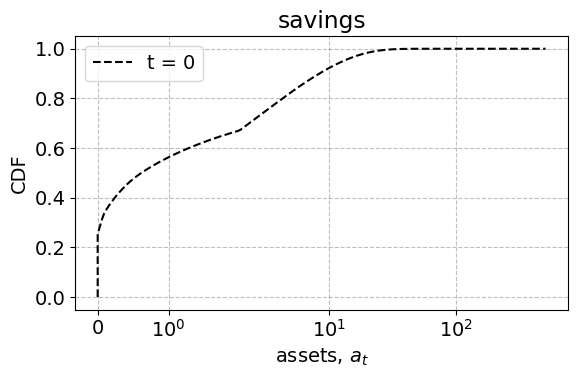

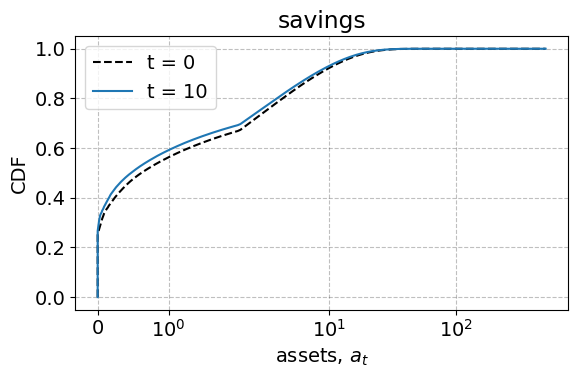

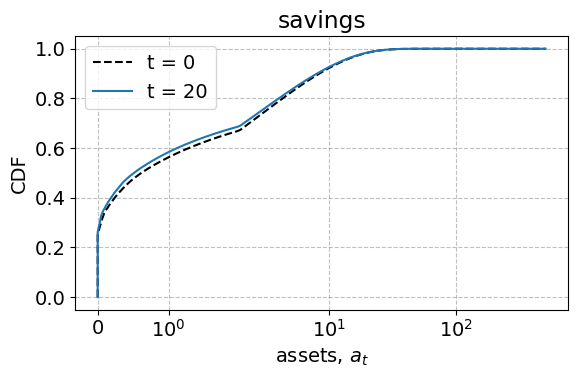

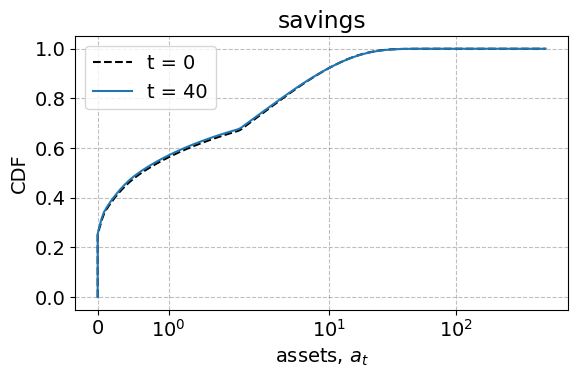

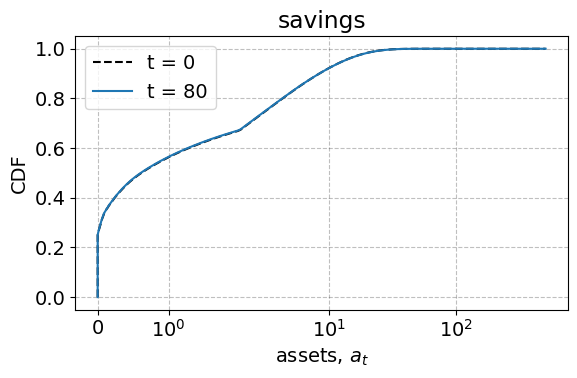

In [28]:
for t in ts:

    fig = plt.figure(figsize=(6,4),dpi=100)

    ax = fig.add_subplot(1,1,1)
    ax.set_title('savings')    

    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[0],axis=(0,1))),0,0.0),label=f't = 0',ls='--',color='black')
    
    if not t == 0:
        ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[t],axis=(0,1))),0,0.0),label=f't = {t}')

    ax.set_xlabel('assets, $a_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f'figs/distribution_path_{t}.pdf')

## 6. <a id='toc6_'></a>[Step 3b: Find linearized IRFs](#toc0_)

In [29]:
model.find_IRFs(shocks=['Gamma'],do_print=True,reuse_G_U=False)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


**Results:** We now have `model.IRF[varname]` with the linear impulse response of all variables.

### shocks ###


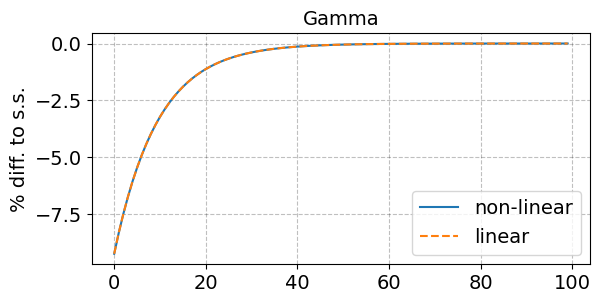


### varnames ###


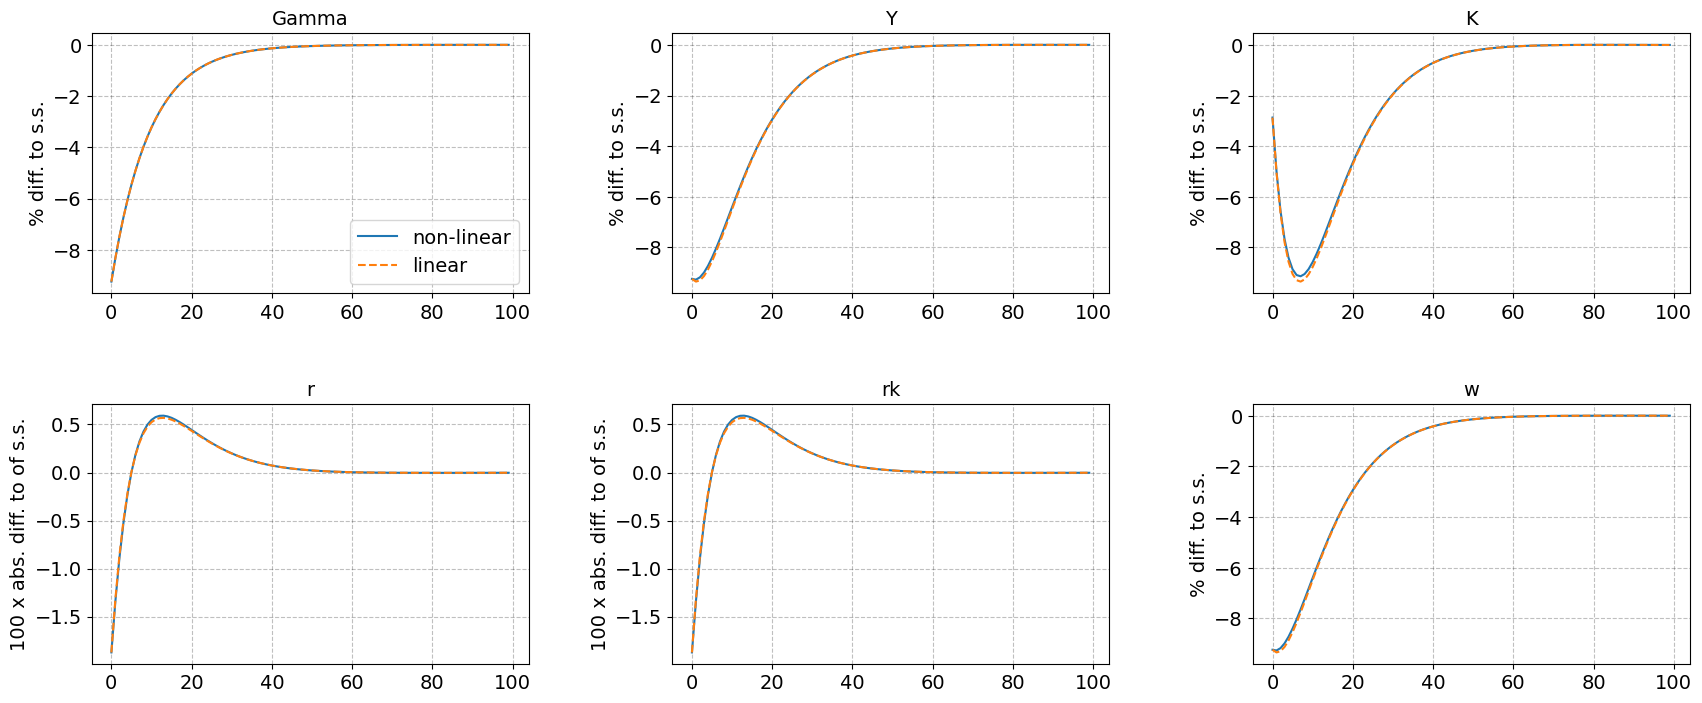


### tagets ###


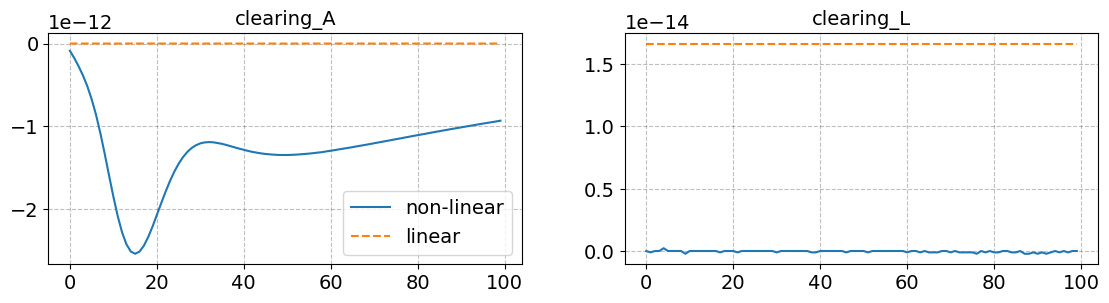

In [30]:
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,do_linear=True)

## 7. <a id='toc7_'></a>[Decompose household behavior](#toc0_)

Find behavior when only some household inputs are active.

['r']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.1 secs

['w']
household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.1 secs

None
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs

all
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs



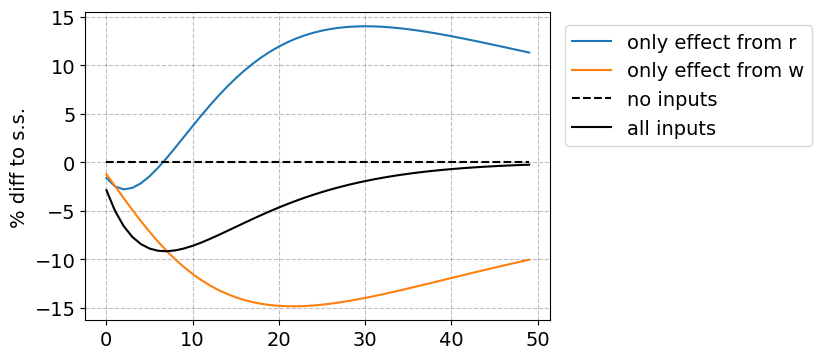

In [31]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['r'],['w'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99));

**Case 2:** Behavior for a subset of households. Here those with zero assets.

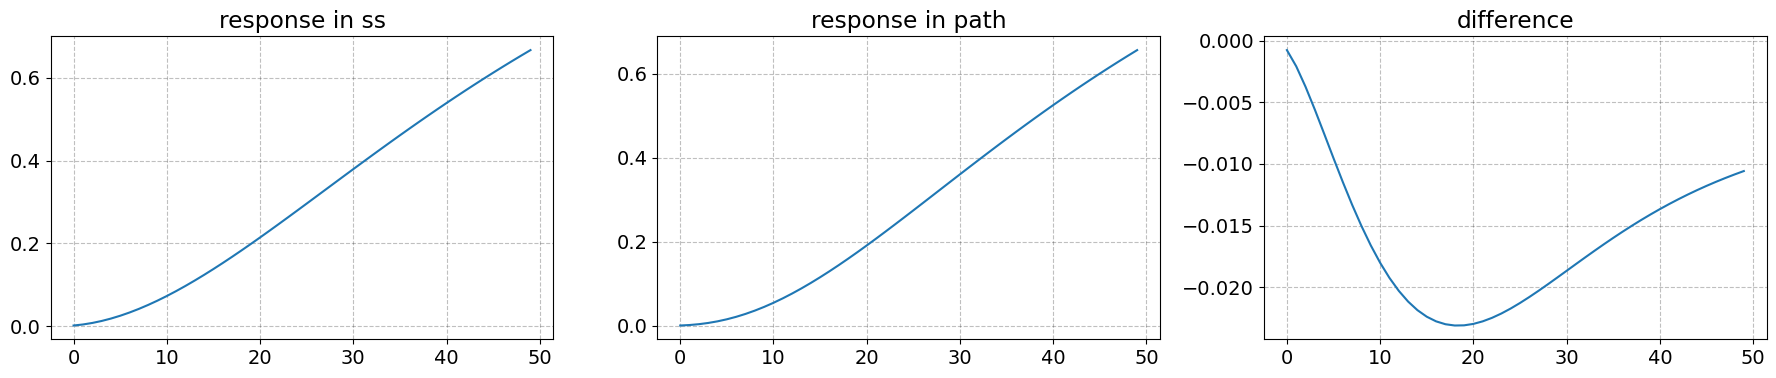

In [32]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response in ss')
ax.plot(path_alt_ss.A_hh[:T_max]);

ax = fig.add_subplot(1,3,2)
ax.set_title('response in path')
ax.plot(path_alt.A_hh[:T_max]);

ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt.A_hh[:T_max]-path_alt_ss.A_hh[:T_max])

fig.tight_layout()

## 8. <a id='toc8_'></a>[Custom shocks](#toc0_)

### 8.1. <a id='toc8_1_'></a>[Path](#toc0_)

In [33]:
# a. define shock
dGamma = np.zeros(par.T)
dGamma[12:24] = 0.01*ss.Gamma
shocks = {'dGamma':dGamma} # note the 'd' for difference (in absolute terms)

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

finding the transition path:
 it =   0 -> max. abs. error = 1.65e-01
   1.65e-01 in clearing_A
   2.59e-14 in clearing_L
 it =   1 -> max. abs. error = 2.45e-03
   2.45e-03 in clearing_A
   4.44e-16 in clearing_L
 it =   2 -> max. abs. error = 5.97e-05
   5.97e-05 in clearing_A
   7.77e-16 in clearing_L
 it =   3 -> max. abs. error = 2.77e-07
   2.77e-07 in clearing_A
   8.88e-16 in clearing_L
 it =   4 -> max. abs. error = 2.74e-09
   2.74e-09 in clearing_A
   6.66e-16 in clearing_L
 it =   5 -> max. abs. error = 6.95e-12
   6.95e-12 in clearing_A
   4.44e-16 in clearing_L

transition path found in 3.4 secs


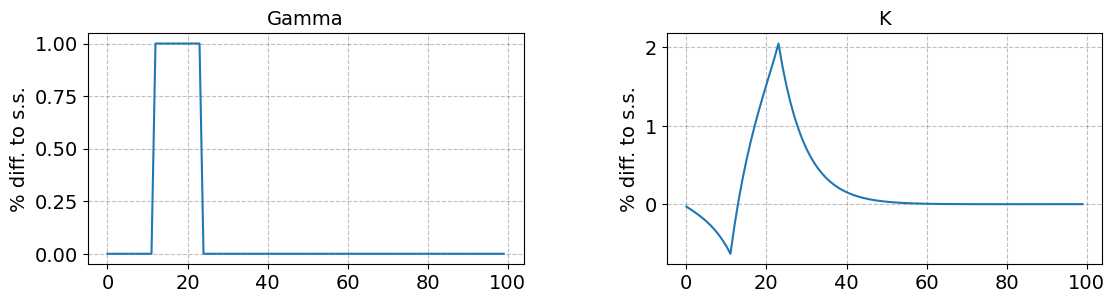

In [34]:
model.show_IRFs(['Gamma','K'],T_max=100,do_shocks=False,do_targets=False,ncols=2,filename='figs/future_technology_shock')

### 8.2. <a id='toc8_2_'></a>[Initial distribution](#toc0_)

**Shock:** Assume everybody looses 5 percent of their wealth.

In [35]:
K_shock = -0.05

**Adjust distribution:**

In [36]:
ini = {}
ini['Dbeg'] = np.zeros(ss.Dbeg.shape)
for i_a_lag in range(par.Na):
    
    # a. assets after shock
    a_lag = par.a_grid[i_a_lag]
    a_lag_after = a_lag*(1+K_shock)
    
    # b. new grid point
    for i in range(par.Na-1):
        if not par.a_grid[i+1] <= a_lag_after: break
    
    # c. distribute mass
    w = (par.a_grid[i+1]-a_lag_after)/(par.a_grid[i+1]-par.a_grid[i])
    
    for i_fix in range(par.Nfix):
        ini['Dbeg'][i_fix,:,i] += w*ss.Dbeg[i_fix,:,i_a_lag]
        ini['Dbeg'][i_fix,:,i+1] += (1-w)*ss.Dbeg[i_fix,:,i_a_lag]    
    

**Calculate new capital stock:**

In [37]:
ini_K = ini['K'] = np.sum(par.a_grid*ini['Dbeg'])
print(f'{ss.K  = :.3f}')
print(f'{ini_K = :.3f}')

ss.K  = 2.775
ini_K = 2.636


**Find transition with no shocks:**

In [38]:
model.find_transition_path(do_print=True,ini=ini,shocks=[]) 

finding the transition path:
 it =   0 -> max. abs. error = 1.33e-01
   1.33e-01 in clearing_A
   2.58e-14 in clearing_L
 it =   1 -> max. abs. error = 7.77e-04
   7.77e-04 in clearing_A
   4.44e-16 in clearing_L
 it =   2 -> max. abs. error = 1.12e-05
   1.12e-05 in clearing_A
   4.44e-16 in clearing_L
 it =   3 -> max. abs. error = 3.02e-08
   3.02e-08 in clearing_A
   3.33e-16 in clearing_L
 it =   4 -> max. abs. error = 2.31e-10
   2.31e-10 in clearing_A
   2.22e-16 in clearing_L
 it =   5 -> max. abs. error = 1.18e-13
   1.18e-13 in clearing_A
   7.77e-16 in clearing_L

transition path found in 3.5 secs


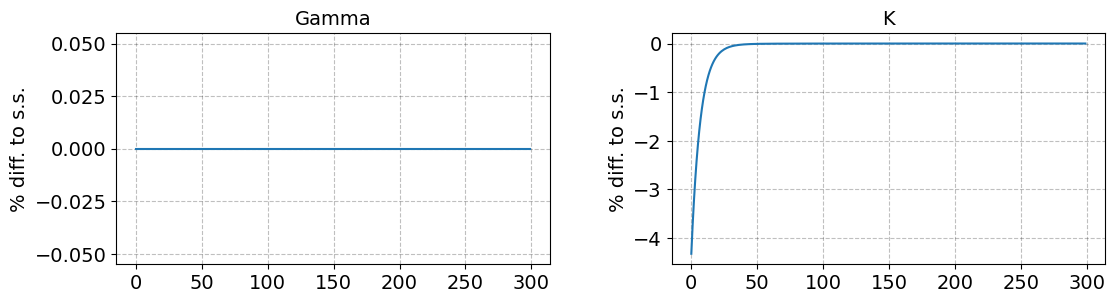

In [39]:
model.show_IRFs(['Gamma','K'],T_max=300,do_shocks=False,do_targets=False,ncols=2,filename='figs/initial_distribution')

## 9. <a id='toc9_'></a>[Step 4. Simulation](#toc0_)

In [40]:
np.random.seed(1917)
model.simulate(do_print=True)

simulation prepared in 4.0 secs [solution matrix: 0.0 secs, households: 4.0 secs]
aggregates simulated in 0.8 secs
household policies simulated in 16.8 secs
distribution simulated in 0.5 secs
aggregates calculated from distribution in 0.1 secs


In [41]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Gamma')
    ax.plot(ss.Gamma+sim.dGamma,ls='--')
    ax.axhline(ss.Gamma,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('K')
    ax.plot(ss.K+sim.dK,ls='--',)
    ax.axhline(ss.K,color='black',zorder=0)

    ax = fig.add_subplot(2,2,3)
    ax.set_title('Compare K')
    ax.plot(ss.K+sim.dK,ls='-',label='linear');
    ax.plot(model.sim.A_hh_from_D,ls='--',label='from D')
    ax.legend(frameon=True)

    ax = fig.add_subplot(2,2,4)
    ax.set_title('... difference')
    ax.plot(model.sim.A_hh_from_D-(ss.K+sim.dK))

    fig.tight_layout()

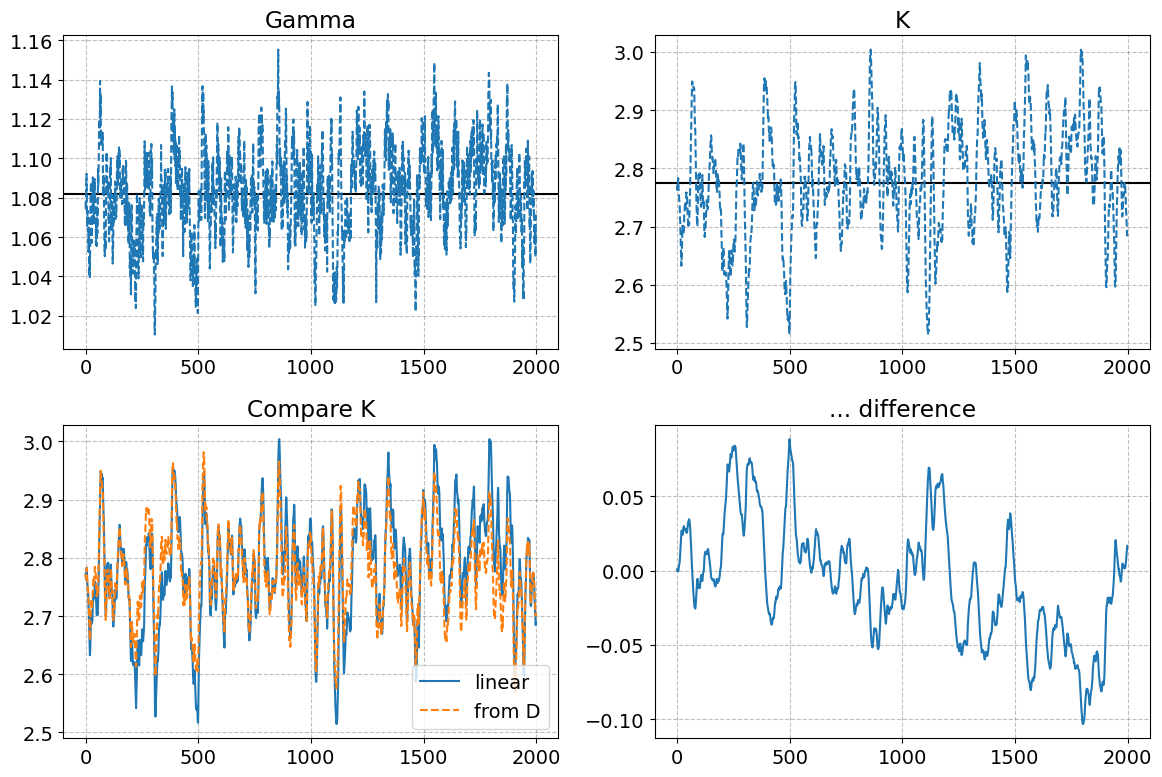

In [42]:
model_sim()

## 10. <a id='toc10_'></a>[Changing unknowns, shocks and targets](#toc0_)

We can update the **update aggregate settings** and automatically reallocate everything, where we consider $L$ as a shock:

In [43]:
model.find_transition_path(shocks=['Gamma'])

In [44]:
model_ = model.copy()
model_.update_aggregate_settings(unknowns=['K'],shocks=['Gamma','L'],targets=['clearing_A'])


We get the exact same results:

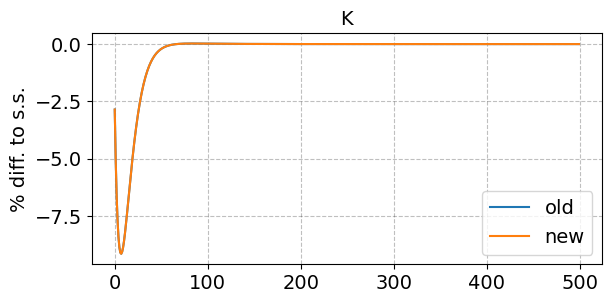

In [45]:
model_.compute_jacs()
model_.find_transition_path(shocks=['Gamma'])
model.compare_IRFs([model,model_],['old','new'],varnames=['K'],do_shocks=False,do_targets=False)

## 11. <a id='toc11_'></a>[Example: Idiosyncratic risk and the steady state interest rate](#toc0_)

In [46]:
print(f'ss.A_hh = ss.K = {ss.A_hh:.2f}')
print(f'ss.r = {ss.r*100:.2f} %')
print('')
      
for sigma_psi in np.linspace(par.sigma_psi,2*par.sigma_psi,5):
    
    print(f'{sigma_psi = :.2f}')

    model_ = model.copy()
    model_.par.sigma_psi = sigma_psi
        
    model_.solve_hh_ss(do_print=False)
    model_.simulate_hh_ss(do_print=False)
    
    A_hh = np.sum(model_.ss.a*model_.ss.D)
    
    print(f'PE {A_hh = :.2f}')
          
    model_.find_ss(method='direct')

    print(f'GE ss.r = {model_.ss.r*100:.2f} %')
    print(f'GE ss.A_hh = ss.K = {model_.ss.A_hh:.2f}')

    print('')

ss.A_hh = ss.K = 2.78
ss.r = 1.00 %

sigma_psi = 0.09
PE A_hh = 2.78
GE ss.r = 1.00 %
GE ss.A_hh = ss.K = 2.78

sigma_psi = 0.12
PE A_hh = 4.83
GE ss.r = 0.62 %
GE ss.A_hh = ss.K = 2.86

sigma_psi = 0.14
PE A_hh = 7.39
GE ss.r = 0.12 %
GE ss.A_hh = ss.K = 2.97

sigma_psi = 0.16
PE A_hh = 10.37
GE ss.r = -0.46 %
GE ss.A_hh = ss.K = 3.12

sigma_psi = 0.19
PE A_hh = 13.68
GE ss.r = -1.11 %
GE ss.A_hh = ss.K = 3.30

